## 循环神经网络（RNN）

#### Sidenote
- Hidden是现实中存在，但是我们没观察到
- Latent是现实中不存在的，可和hidden互换

### 潜变量自回归模型
- 潜变量h用于总结过去的信息
![](./imgs/54-7.png)

### 循环神经网络
- RNN与MLP的区别是: 用额外的$W_{hh}$来存时序信息
- $h_t$用的是$x_{t-1}$的内容,而不是$x_{t}$的内容
- 计算损失的时候是比较$o_t$和$x_{t}$去计算损失
- $\fai$是激活函数
![](./imgs/54-2.png)

### 困惑度(perplexity)
- 衡量一个语言模型的好坏可以用平均交叉熵
- n是字典长度，$x_t$是真实词，p是语言模型的预测概率
![](./imgs/54-8.png)
- 历史原因NLP使用困惑度$exp(\pi)$来衡量(平均交叉熵取指数),表示每一次的可能选项
- 1表示完美，无穷是最大的情况

### 梯度剪裁（Gradient Clip）
- 在迭代中，计算这T个时间步上的梯度，在反向传播过程中，会产生长度为O(T)的矩阵乘法链，会导致数值不稳定
- 梯度剪裁能有效预防梯度爆炸
- 下式中的g表示所有层的梯度，全部放在一个向量里
- 这个式子表达的意思是，假设g的长度大于theta，则投影回theta
![](./imgs/54-5.png)

### 更多RNN的应用
![](./imgs/54-6.png)

### 总结
- RNN的输出取决于当前输入和前一时间的隐变量
- 使用perplexity来衡量语言模型的好坏
- 应用到语言模型中，RNN根据当前时刻词预测下一时刻词

## RNN从零开始实现

In [3]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import d2l

In [6]:
# num_steps每一次看多长的序列

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# vocal的用处是整数和词的转化

### One-hot 编码介绍

In [7]:
# index -> one-hot
F.one_hot(torch.tensor([0, 2]), len(vocab)) # [0, 2]
# 第一个变量是label，第二个变量是number_of_class
# 这样返回基于第一个变量的对应的one-hot编码

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [8]:
# 对一个batch进行one-hot编码
X = torch.arange(10).reshape((2, 5))  # 最后一个维度是时间
# 这里需要做转置，X.T: [T,B,L]
F.one_hot(X.T, 28),X.T,F.one_hot(X.T, 28).shape

(tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0,

### 初始化RNN的参数

In [9]:
def get_params(vocab_size, num_hiddens, device):
    
    num_inputs = num_outputs = vocab_size # 因为经过了onehot，所以输入长度等于vocab_size
    
    # 一个辅助函数: 初始化函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens)) # 挪掉这一行就是MLP
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 给这些参数加入梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [10]:
# 初始化隐藏状态: 因为0时刻没有隐藏状态，需要自己初始化
def init_rnn_state(batch_size, num_hiddens, device):
    # 隐藏状态放在一个tuple里(之后会有多个隐藏状态)
    return (torch.zeros((batch_size, num_hiddens), device=device), ) # 也可以换成随机

### 在一个time-step内计算隐藏状态和输出

In [11]:
def rnn(inputs, state, params):
    # `inputs`的形状：(`time_step数量`，`批量大小`，`词表大小`)
    # input里其实有time_step个样本
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state # state是一个tuple，里面只有一个H
    outputs = []
    # `X`的形状：(`批量大小`，`词表大小`)
    for X in inputs: # 这里的X会沿着第0个维度去遍历，对time_step个样本进行遍历
        H = torch.tanh(torch.mm(X, W_xh) 
                       + torch.mm(H, W_hh)  # 这一行的H是前一个时刻的隐藏状态
                       + b_h) # 
        Y = torch.mm(H, W_hq) + b_q # 这里的H是当前时刻的隐藏状态
        outputs.append(Y)  # outputs最后的尺寸为(time_step,batchsize)
        # torch.cat(outputs, dim=0)在第0维去拼出来，列数还是vocab size，行数是batchsize*time_step
    return torch.cat(outputs, dim=0), (H,) # 还要输出当前的隐藏状态

### 创建一个class来包装这些函数

In [12]:
class RNNModelScratch: #
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn # forward_fn就是上一个cell定义的rnn

    def __call__(self, X, state): # 用call和用forward都可以进行前向传播
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    # 初始状态
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [13]:
# 检查输出是否正确
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu()) # 第0维是batchsize
# X = torch.arange(10).reshape((2, 5)) 
Y, new_state = net(X.to(d2l.try_gpu()), state)
# y的第一个维度是batch_size*time_step:2*5
# y的第二个维度是one-hot编码的预测
# new_state是更新后的隐藏状态，长为1的tuple
# new_state[0].shape: (batchsize,num_hiddens)
Y.shape, len(new_state), new_state[0].shape 

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 定义预测函数来生成`prefix`后面的新字符

In [14]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    #
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]] 
    # [outputs[-1]]就是最近预测的那个词，作为下一次预测的输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 因为prefix[0]已经丢入output里了
        _, state = net(get_input(), state) # 用已有的prefix去计算隐藏层的状态
        outputs.append(vocab[y]) # 这里放的是真实值
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1))) # 最大的拿出来，reshape成一个标量，放到outputli qu 
    # 整型转成字符串
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [15]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())
# 这里的net还没训练

'time traveller ahgqofbofb'

### 梯度剪裁

In [16]:
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta: 
        for param in params:
            param.grad[:] *= theta / norm

### Train一个epoch

In [17]:
def train_epoch_ch8(net, train_iter, loss, updater, device, 
                    use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer() # state是隐藏层的信息
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`。
            # use_random_iter意味着时序上不连续，就要初始化state.
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_() # state
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) # y也拉成向量
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        # 本质上就是一个多分类问题
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) #gradient clipping
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [18]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss() # 因为本质是多分类，所以用entropyloss
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.8, 60993.0 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


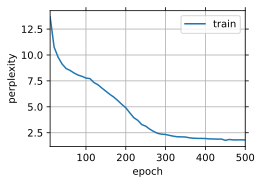

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 58226.7 词元/秒 cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller with a slight accession ofcheerfulness really thi


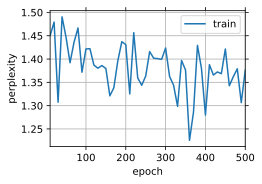

In [20]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)